# Assignment 3: Creating a WordyPy Solver

You now understand the rules of _WordyPy_ and how to read the game state from an image. Now your job is to read in a
_WordyPy_ partial play and provide a next **good** guess. What's a good guess? A good guess is one which:

1. Continues to adhere to the rules of _WordPy_
2. Does not repeat words which have already been played
3. Uses the knowledge of previous guesses to pick a new good word

Unlike previous assignments there are no guardrails for this task -- you can complete this using whatever software
architecture you like! In addition, I've put my code in a new module for you to import, called `wordy`. You can just
import this module and begin making calls to it. You should be able to understand how it works by reading the module
documentation.


In [96]:
import wordy
import PIL
import pytesseract
class Letter:
    def __init__(self, letter):
        self.letter = letter
        self.in_correct_place = False
        self.in_word = False
    def is_in_correct_place(self):
        return self.in_correct_place
    def is_in_word(self):
        return self.in_word
    
class Bot:
    def __init__(self, word_list_file, display_spec):
        self.word_list = []
        self.clues = []
        self.letters = []
        self.not_in_letters = []
        self.indexes = []
        self.display_spec = display_spec
        self.word_list = word_list_file          
        
    def make_guess(self):
        choice = ""
        guess_results = []
        
        while len(choice) == 0:
            #print(self.word_list)
            choice = self.word_list.pop()
            if choice in self.clues:
                choice = ""
            else:
                if len(self.letters) > 0:
                    for l in self.letters:
                        if l not in choice:
                            choice = ""
                            break
                if len(choice) > 0 and len(self.not_in_letters) > 0:
                    for l in self.not_in_letters:
                        if l in choice:
                            choice = ""
                            break
                if len(choice) > 0 and len(self.indexes) > 0:
                    for (i, l) in self.indexes:
                        if choice[i] != l:
                            choice = ""
                            break
                        
        return choice
        
    def record_guess_results(self, guess, image_results):
        print('guess', guess)
        guess_results = self._process_image(guess, image_results)
        clue = ""
        for index, l in enumerate(guess_results):
            clue += l.letter
            if l.is_in_word():
                print(l.letter, "is in word")
                if l.letter not in self.letters:
                    self.letters.append(l.letter)
            else:
                self.not_in_letters.append(l.letter)
            if l.is_in_correct_place():
                print(index, l.letter, "is in correct place")
                if (index, l.letter) not in self.indexes:
                    self.indexes.append((index, l.letter))
                    
        print('clue', clue)
        print('letters', self.letters)
        print('not in letter', self.not_in_letters)
        print('positions', self.indexes)
        self.clues.append(clue)
        
    def _tuple_to_str(self, pixels):
        pixel_str = "#"
        for pixel in pixels:
            pixel_str += f"{pixel:0{2}x}"
        return pixel_str.upper()
    
    def _process_image(self, guess, image_results):
        letters = []
        width = image_results.width
        height = image_results.height
        step = self.display_spec.block_width
        left = 0
        upper = 0
        right = left + step
        lower = upper + height
        guess_results = []
        correct = False
        inword = False
        incorrect = False
        l_position = 0
        #print('spec', self.display_spec)
        while left < width:
            #letter_img = image_results.crop((left, upper, right, lower))
            pixel_color = image_results.getpixel((left, upper))
            #print(pixel_color)
            #print('hex:', self._tuple_to_str(pixel_color))
            hex_color = self._tuple_to_str(pixel_color)
            if hex_color == self.display_spec.correct_location_color:
                correct = True
                inword = True
            if hex_color == self.display_spec.incorrect_location_color:
                correct = False
                inword = True
            if hex_color == self.display_spec.incorrect_color:
                incorrect = True
                
            #print(l_position, 'correct:', correct, 'inword:', inword, 'incorrect:', incorrect)
            letter = Letter(guess[l_position])
            letter.in_correct_place = correct
            letter.in_word = inword
            letters.append(letter)
            #display(letter_img)        
            left = left + self.display_spec.space_between_letters + step
            right = left + step
            lower = upper + height   
            l_position += 1
            correct = False
            inword = False
            incorrect = False
        return letters



def solution(board: PIL.Image) -> str:
    """The student solution to the problem.

    You must write code to query the wordy module and make
    a guess for the word. You needs to inspect the module to
    understand how to do this, and this function should only return
    the guess that you are going to make based on the game board state.

    Returns:
        str: The guess that you are going to make.
    """
    new_guess = ""
    # YOUR CODE HERE
    display(board)
    print('width', board.width)
    print('height', board.height)
    display_spec = wordy.get_display_spec()
    print('spec height', display_spec.block_height)
    
    left = 0
    upper = 0
    right = board.width
    lower = upper + display_spec.block_height
    word_list = wordy.get_word_list()
    bot = Bot(word_list, wordy.get_display_spec())
    word = ""
    custom_config = r'-c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    
    total_letters = board.width // display_spec.block_width
    
    while upper < board.height:
        img = board.crop((left, upper, right, lower))
        #display(img)
        upper += display_spec.block_height
        lower = upper + display_spec.block_height
        word = word_list.pop()

        white = (255, 255, 255)
        red = (255, 0, 0)

        # Replace white pixels with red
        black_white_img = img.copy()
        pixels = black_white_img.load()  # Create a pixel map
        for x in range(black_white_img.width):
            for y in range(black_white_img.height):
                if pixels[x, y] == white:
                    pixels[x, y] = red
                else:
                    pixels[x, y] = white
        
        #display(black_white_img)
        ocr = pytesseract.image_to_string(black_white_img, config=custom_config)
        
        if len(ocr) > total_letters:
            ocr = ocr.replace("I","")
            ocr = ocr.replace("J","")
            
        print('ocr len:', len(ocr), 'total letters', total_letters)
        if len(ocr)-1 == total_letters:
            bot.record_guess_results(ocr,img)
            word = bot.make_guess()
            #print('-'*10)
            #print('found:', ocr)
            #print('learning with word:', ocr)
            #print('guessed:', word)
            #print('-'*10)
    
    new_guess = word
    print('guessing using word:', new_guess)
    return new_guess

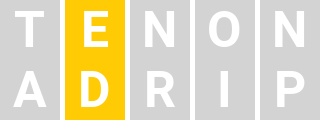

width 320
height 120
spec height 60
ocr len: 6 total letters 5
guess TENON

E is in word
clue TENON
letters ['E']
not in letter ['T', 'N', 'O', 'N']
positions []
ocr len: 5 total letters 5
guessing using word: VIMEN


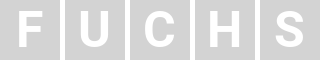

width 320
height 60
spec height 60
ocr len: 6 total letters 5
guess FUCHS

clue FUCHS
letters []
not in letter ['F', 'U', 'C', 'H', 'S']
positions []
guessing using word: ELEVE


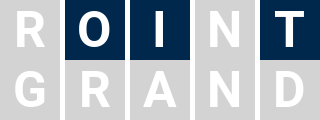

width 320
height 120
spec height 60
ocr len: 5 total letters 5
ocr len: 6 total letters 5
guess GRAND

clue GRAND
letters []
not in letter ['G', 'R', 'A', 'N', 'D']
positions []
guessing using word: ELEVE


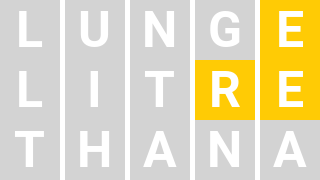

width 320
height 180
spec height 60
ocr len: 6 total letters 5
guess LUNGE

E is in word
clue LUNGE
letters ['E']
not in letter ['L', 'U', 'N', 'G']
positions []
ocr len: 6 total letters 5
guess LTTRE

R is in word
E is in word
clue LTTRE
letters ['E', 'R']
not in letter ['L', 'U', 'N', 'G', 'L', 'T', 'T']
positions []
ocr len: 6 total letters 5
guess THANA

clue THANA
letters ['E', 'R']
not in letter ['L', 'U', 'N', 'G', 'L', 'T', 'T', 'T', 'H', 'A', 'N', 'A']
positions []
guessing using word: RESOW


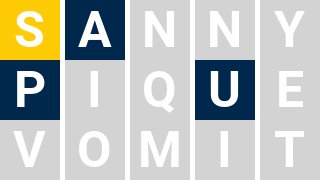

width 320
height 180
spec height 60
ocr len: 6 total letters 5
guess SANNY

S is in word
A is in word
1 A is in correct place
clue SANNY
letters ['S', 'A']
not in letter ['N', 'N', 'Y']
positions [(1, 'A')]
ocr len: 5 total letters 5
ocr len: 5 total letters 5
guessing using word: PURIM


In [97]:
# The autograder for this assignment is easy, it will try and play
# a few rounds of the game and ensure that errors are not thrown. If
# you can make it through five rounds we'll assume you have the right
# solution!
#
# You SHOULD NOT change anything in the wordy module, instead you
# must figure out how to write the solution() function in this notebook
# to make a good guess based on the board state!

for i in range(5):
    try:
        # Get an image of the current board state from wordy.
        # Note that the image contains some number of random guesses (always less than 5 guesses).
        image = wordy.get_board_state()
        # Create a new *good* guess based on the image and rules of wordy
        new_guess = solution(image)  # your code goes in solution()!
        # Send that guess to wordy to make sure it doesn't throw any errors
        wordy.make_guess(new_guess)
    except Exception as e:
        raise e